In [1]:
# !pip install ipywidgets transformers[torch] datasets ipywidgets torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [2]:
import requests
from PIL import Image
import torch
from transformers import BlipProcessor, BlipForQuestionAnswering, BlipImageProcessor, AutoProcessor
from transformers import BlipConfig
from datasets import load_dataset
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
print(requests.__version__)

2.32.4


# Finetune BLIP1(base) - VQARAD - 100 epochs

In [4]:
from datasets import load_dataset
dataset = load_dataset("flaviagiammarino/vqa-rad")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001-eb8844602202be(…):   0%|          | 0.00/24.2M [00:00<?, ?B/s]

data/test-00000-of-00001-e5bc3d208bb4dee(…):   0%|          | 0.00/10.3M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1793 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/451 [00:00<?, ? examples/s]

In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'question', 'answer'],
        num_rows: 1793
    })
    test: Dataset({
        features: ['image', 'question', 'answer'],
        num_rows: 451
    })
})

Question: are the lungs normal appearing?
Answer: no


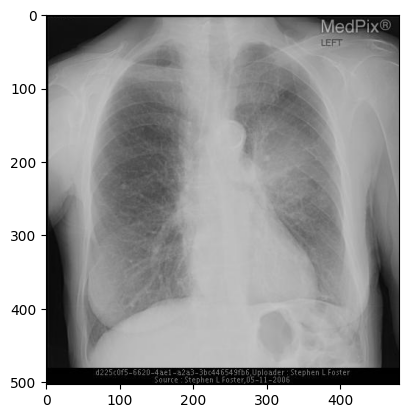

In [6]:
sample = dataset['train'][1]
PIL_image = Image.fromarray(np.array(sample['image'])).convert('RGB')
plt.imshow(sample['image'].convert('RGB'))
print("Question: {}".format(sample['question']))
print("Answer: {}".format(sample['answer']))

In [7]:
config = BlipConfig.from_pretrained("Salesforce/blip-vqa-base")

config.json: 0.00B [00:00, ?B/s]

In [8]:
class VQADataset(torch.utils.data.Dataset):
    def __init__(self, data, segment, text_processor, image_processor):
        self.data = data
        self.questions = data['question']
        self.answers = data['answer']
        self.text_processor = text_processor
        self.image_processor = image_processor
        self.max_length = 32
        self.image_height = 128
        self.image_width = 128

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # get image + text
        answers = self.answers[idx]
        questions = self.questions[idx]
        image = self.data[idx]['image'].convert('RGB')
        text = self.questions[idx]

        image_encoding = self.image_processor(image,
                                  do_resize=True,
                                  size=(self.image_height,self.image_width),
                                  return_tensors="pt")


        encoding = self.text_processor(
            text=text, # Передавайте явно как именованный аргумент
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        # # remove batch dimension
        for k,v in encoding.items():
            encoding[k] = v.squeeze()

        encoding["pixel_values"] = image_encoding["pixel_values"][0]

        # # add labels
        labels = self.text_processor.tokenizer.encode(
            answers,
            max_length= self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors='pt'
        )[0]

        encoding["labels"] = labels

        return encoding

In [9]:
text_processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
image_processor = BlipImageProcessor.from_pretrained("Salesforce/blip-vqa-base")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [10]:
split_ds = dataset['train'].train_test_split(test_size=0.15, seed=42)

train_data = split_ds['train']
val_data = split_ds['test']
test_data = dataset['test']

In [11]:
train_vqa_dataset = VQADataset(data=train_data,
                     segment='train',
                     text_processor = text_processor,
                     image_processor = image_processor
                         )

val_vqa_dataset = VQADataset(data=val_data,
                     segment='test',
                     text_processor = text_processor,
                     image_processor = image_processor
                         )

test_vqa_dataset = VQADataset(data=test_data,
                     segment='test',
                     text_processor = text_processor,
                     image_processor = image_processor
                         )

In [12]:
train_vqa_dataset[0]

{'input_ids': tensor([  101,  2024,  2045,  2151, 21908,  9556,  1029,   102,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0]), 'pixel_values': tensor([[[-0.7558, -1.7923, -1.7923,  ..., -1.7339, -1.7339, -1.7485],
         [-1.2813, -1.7923, -1.7923,  ..., -1.7923, -1.7923, -1.7923],
         [-1.2667, -1.7923, -1.7923,  ..., -1.4273, -1.7923, -1.7923],
         ...,
         [-1.7631, -1.7631, -1.7631,  ..., -1.7777, -1.7777, -1.7777],
         [-1.7777, -1.7777, -1.7777,  ..., -1.7777, -1.7777, -1.7777],
         [-1.7777, -1.7777, -1.7777,  ..., -1.7777, -1.7777, -1.7777]],

        [[-0.6865, -1.7521, -1.7521,  ..., -1.6921, -1.6921, -1.7071],
         [-1.2268, -1.7521, -1.7521,  ..., -1.7521, -1.7521, -1.752

In [13]:
def collate_fn(batch):
    input_ids = [item['input_ids'] for item in batch]
    pixel_values = [item['pixel_values'] for item in batch]
    attention_mask = [item['attention_mask'] for item in batch]
    labels = [item['labels'] for item in batch]
    # create new batch
    batch = {}
    batch['input_ids'] = torch.stack(input_ids)
    batch['attention_mask'] = torch.stack(attention_mask)
    batch['pixel_values'] = torch.stack(pixel_values)
    batch['labels'] = torch.stack(labels)

    return batch

train_dataloader = DataLoader(train_vqa_dataset,
                              collate_fn=collate_fn,
                              batch_size=32,
                              shuffle=False)

val_dataloader = DataLoader(val_vqa_dataset,
                            collate_fn=collate_fn,
                            batch_size=32,
                            shuffle=False)

test_dataloader = DataLoader(test_vqa_dataset,
                            collate_fn=collate_fn,
                            batch_size=32,
                            shuffle=False)

In [14]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
    print(k, v.shape)

input_ids torch.Size([32, 32])
attention_mask torch.Size([32, 32])
pixel_values torch.Size([32, 3, 128, 128])
labels torch.Size([32, 32])


In [15]:
from PIL import Image
import requests
from transformers import AutoProcessor, BlipForQuestionAnswering

model.safetensors:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

In [17]:
image_mean = image_processor.image_mean
image_std = image_processor.image_std

Question:  [CLS] which lobe is the lesion in? [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
Answer:  [CLS] left parietal lobe [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


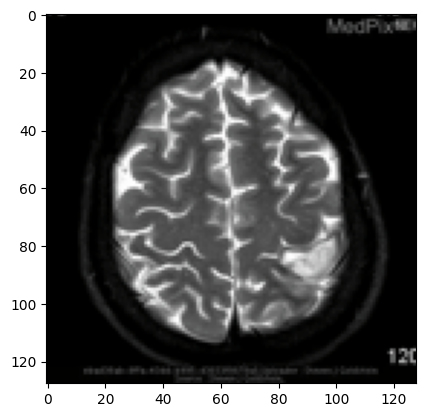

In [18]:
batch_idx = 1

unnormalized_image = (batch["pixel_values"][batch_idx].cpu().numpy() * np.array(image_std)[:, None, None]) + np.array(image_mean)[:, None, None]
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)


print("Question: ",text_processor.decode(batch["input_ids"][batch_idx]))
print("Answer: ",text_processor.decode(batch["labels"][batch_idx]))
plt.imshow(Image.fromarray(unnormalized_image))

In [24]:
import os

from google.colab import drive
drive.mount('/content/drive')
base_dir= "/content/drive/MyDrive/Malaysia/Advanced_Machine_Learning/Alternative assesment"
os.makedirs(base_dir, exist_ok=True)

Mounted at /content/drive


In [34]:
model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base")
model.cuda()
processor = AutoProcessor.from_pretrained("Salesforce/blip-vqa-base")

optimizer = torch.optim.AdamW(model.parameters(), lr=8e-6, weight_decay=5e-2)

In [ ]:
# Настройки сохранения
base_dir= "/content/drive/MyDrive/Malaysia/Advanced_Machine_Learning/Alternative assesment"

best_val_acc = 0.0
patience = 5  # Через сколько эпох без улучшений остановить обучение
counter = 0

model.train()

history = {
    'train_loss': [], 'val_loss': [],
    'train_acc': [], 'val_acc': []
}

for epoch in range(100):
    print(f"Epoch: {epoch}")
    total_loss = 0
    total_correct = 0
    total_samples = 0

    for batch in tqdm(train_dataloader):
        # get the inputs;
        batch = {k:v.to(device) for k,v in batch.items()}
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        model.train()
        outputs = model(
            input_ids= batch['input_ids'],
            attention_mask= batch['attention_mask'],
            pixel_values= batch['pixel_values'],
            labels= batch['labels'],
        )
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

        model.train()
        with torch.no_grad():
          input_ids = batch['input_ids'].detach().clone().to(device)
          #torch.tensor(batch['input_ids']).to(device)

          # Generate predictions
          predictions = model.generate(
              pixel_values=batch['pixel_values'],
              input_ids=input_ids,  # Pass input_ids as tensor
              attention_mask=batch['attention_mask'],
              max_length=32
          )

          # Decode predictions and labels
          decoded_preds = processor.batch_decode(predictions, skip_special_tokens=True)
          decoded_labels = processor.batch_decode(batch['labels'], skip_special_tokens=True)

          # Calculate accuracy
          for pred, label in zip(decoded_preds, decoded_labels):
              if pred.strip().lower() == label.strip().lower():
                  total_correct += 1
              total_samples += 1

    avg_train_loss = total_loss / len(train_dataloader)
    train_accuracy = total_correct / total_samples

    history['train_loss'].append(avg_train_loss)
    history['train_acc'].append(train_accuracy)

    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():  # Disable gradient computation for evaluation
        for batch in tqdm(val_dataloader):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(
                input_ids= batch['input_ids'],
                attention_mask= batch['attention_mask'],
                pixel_values= batch['pixel_values'],
                labels= batch['labels'],
            )
            loss = outputs.loss
            total_loss += loss.item()

            # Convert input_ids to tensor
            input_ids = batch['input_ids'].detach().clone().to(device)
            #torch.tensor(batch['input_ids']).to(device)

            # Generate predictions
            predictions = model.generate(
                pixel_values=batch['pixel_values'],
                input_ids=input_ids,  # Pass input_ids as tensor
                attention_mask=batch['attention_mask'],
                max_length=32
            )

            # Decode predictions and labels
            decoded_preds = processor.batch_decode(predictions, skip_special_tokens=True)
            decoded_labels = processor.batch_decode(batch['labels'], skip_special_tokens=True)

            # Calculate accuracy
            for pred, label in zip(decoded_preds, decoded_labels):
                if pred.strip().lower() == label.strip().lower():
                    total_correct += 1
                total_samples += 1

    avg_val_loss = total_loss / len(val_dataloader)
    val_accuracy = total_correct / total_samples

    history['val_loss'].append(avg_val_loss)
    history['val_acc'].append(val_accuracy)

    print(f"train_avg_loss: {avg_train_loss}, train_avg_acc: {train_accuracy}")
    print(f"val_avg_loss: {avg_val_loss}, val_avg_acc: {val_accuracy}")

    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        counter = 0
        # Сохраняем не только веса, но и состояние оптимизатора
        checkpoint_folder= f"{base_dir}/blip1_lr_1e-5/"
        os.makedirs(checkpoint_folder, exist_ok=True)
        checkpoint_path = f"{checkpoint_folder}blip1(base)-vqarad-adamW-best_epochs.pth"
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_val_loss,
            'acc': avg_val_loss
        }, checkpoint_path)
        print(f"New best model saved with Accuracy: {best_val_acc:.4f}")
    else:
        counter += 1
        print(f"No improvement for {counter} epochs. ---")

    if counter >= patience:
        print(f"Early stopping triggered at epoch {epoch}. Training stopped.")
        break

Epoch: 0


  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

train_avg_loss: 8.984242022037506, train_avg_acc: 0.3136482939632546
val_avg_loss: 8.165756119622124, val_avg_acc: 0.31226765799256506
New best model saved with Accuracy: 0.3123
Epoch: 1


  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

train_avg_loss: 7.549272884925206, train_avg_acc: 0.3746719160104987
val_avg_loss: 6.9836374918619795, val_avg_acc: 0.34944237918215615
New best model saved with Accuracy: 0.3494
Epoch: 2


  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

train_avg_loss: 6.466025451819102, train_avg_acc: 0.43241469816272965
val_avg_loss: 6.003938727908665, val_avg_acc: 0.37174721189591076
New best model saved with Accuracy: 0.3717
Epoch: 3


  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

train_avg_loss: 5.443448672691981, train_avg_acc: 0.4954068241469816
val_avg_loss: 4.939237594604492, val_avg_acc: 0.39776951672862454
New best model saved with Accuracy: 0.3978
Epoch: 4


  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

train_avg_loss: 4.388498152295749, train_avg_acc: 0.5597112860892388
val_avg_loss: 3.9568539460500083, val_avg_acc: 0.4163568773234201
New best model saved with Accuracy: 0.4164
Epoch: 5


  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

train_avg_loss: 3.412423183520635, train_avg_acc: 0.6253280839895013
val_avg_loss: 3.0290346410539417, val_avg_acc: 0.4200743494423792
New best model saved with Accuracy: 0.4201
Epoch: 6


  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

train_avg_loss: 2.504388694961866, train_avg_acc: 0.652230971128609
val_avg_loss: 2.1900555557674832, val_avg_acc: 0.4200743494423792
No improvement for 1 epochs. ---
Epoch: 7


  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

train_avg_loss: 1.7179213712612789, train_avg_acc: 0.6679790026246719
val_avg_loss: 1.5051103830337524, val_avg_acc: 0.43866171003717475
New best model saved with Accuracy: 0.4387
Epoch: 8


  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

train_avg_loss: 1.1211219057440758, train_avg_acc: 0.7165354330708661
val_avg_loss: 1.0399994121657476, val_avg_acc: 0.4312267657992565
No improvement for 1 epochs. ---
Epoch: 9


  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

train_avg_loss: 0.7382423765957355, train_avg_acc: 0.7506561679790026
val_avg_loss: 0.7528246773613824, val_avg_acc: 0.45724907063197023
New best model saved with Accuracy: 0.4572
Epoch: 10


  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

train_avg_loss: 0.5125304398437341, train_avg_acc: 0.7808398950131233
val_avg_loss: 0.5933934615717994, val_avg_acc: 0.45724907063197023
No improvement for 1 epochs. ---
Epoch: 11


  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

train_avg_loss: 0.3799768916020791, train_avg_acc: 0.7985564304461942
val_avg_loss: 0.5025823778576322, val_avg_acc: 0.44981412639405205
No improvement for 2 epochs. ---
Epoch: 12


  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

train_avg_loss: 0.2979893550897638, train_avg_acc: 0.8208661417322834
val_avg_loss: 0.4435957007937961, val_avg_acc: 0.4721189591078067
New best model saved with Accuracy: 0.4721
Epoch: 13


  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

train_avg_loss: 0.24433902899424234, train_avg_acc: 0.8248031496062992
val_avg_loss: 0.399629318051868, val_avg_acc: 0.4795539033457249
New best model saved with Accuracy: 0.4796
Epoch: 14


  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

train_avg_loss: 0.20677678876866898, train_avg_acc: 0.8307086614173228
val_avg_loss: 0.3723935517999861, val_avg_acc: 0.49070631970260226


In [ ]:
import matplotlib.pyplot as plt


def plot_comprehensive_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(18, 5))

    # 1. Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'b-', label='Train Loss')
    plt.plot(epochs, history['val_loss'], 'r-', label='Val Loss')
    plt.title('Loss Dynamics')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # 2. Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], 'b-', label='Train Acc')
    plt.plot(epochs, history['val_acc'], 'r-', label='Val Acc')
    plt.title('Accuracy Dynamics')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_comprehensive_history(history)

In [ ]:
# Assuming 'model' is your fine-tuned model and 'processor' is your tokenizer/processor
base_dir= "/content/drive/MyDrive/Malaysia/Advanced_Machine_Learning/Alternative assesment"
save_directory = f"{base_dir}/blip1(base)-vqarad-adamW-100epochs.pth"

# Save the fine-tuned model and processor locally
model.save_pretrained(save_directory)
#text_processor.save_pretrained(save_directory)
#image_processor.save_pretrained(save_directory)
processor.save_pretrained(save_directory)
print(f"Fine-tuned model and processor saved to {save_directory}")

In [25]:
import torch
import os

checkpoint_path = f"{base_dir}/blip1_lr_1e-5/blip1(base)-vqarad-adamW-best_epochs.pth"
checkpoint = torch.load(checkpoint_path, map_location=device)

model.load_state_dict(checkpoint['model_state_dict'])

optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
model.eval()


✅ Success! Loaded checkpoint from epoch 2
🎯 Best Accuracy recorded: 0.3318
📉 Best Loss recorded: 0.3318


In [26]:
def evaluate_model(model, dataloader, processor, device):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():  # Disable gradient computation for evaluation
        for batch in tqdm(dataloader):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            total_loss += loss.item()

            # Convert input_ids to tensor
            input_ids = torch.tensor(batch['input_ids']).to(device)

            # Generate predictions
            predictions = model.generate(
                pixel_values=batch['pixel_values'],
                input_ids=input_ids,  # Pass input_ids as tensor
                attention_mask=batch['attention_mask'],
                max_length=32
            )

            # Decode predictions and labels
            decoded_preds = processor.batch_decode(predictions, skip_special_tokens=True)
            decoded_labels = processor.batch_decode(batch['labels'], skip_special_tokens=True)

            # Calculate accuracy
            for pred, label in zip(decoded_preds, decoded_labels):
                if pred.strip().lower() == label.strip().lower():
                    total_correct += 1
                total_samples += 1

    avg_val_loss = total_loss / len(dataloader)
    val_accuracy = total_correct / total_samples
    return avg_val_loss, val_accuracy

# Evaluate the model
val_loss, val_accuracy = evaluate_model(model, test_dataloader, processor, device)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

  0%|          | 0/15 [00:00<?, ?it/s]

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
/tmp/ipython-input-3083669504.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(batch['input_ids']).to(device)


Validation Loss: 0.44348657528559365
Validation Accuracy: 0.43680709534368073


Question:  can you see the esophagus in this image?
Predicted Answer:  
Actual Answer:  no


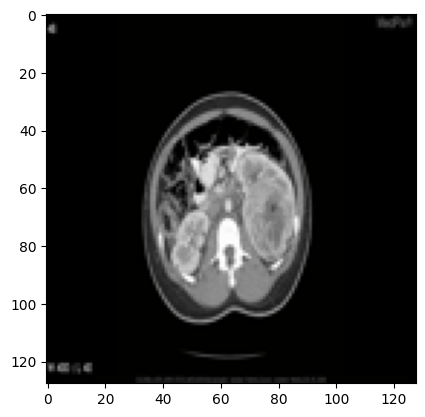

In [32]:
idx = 30
sample = test_vqa_dataset[idx]
print("Question: ",text_processor.decode(sample['input_ids'], skip_special_tokens=True))
sample = {k: v.unsqueeze(0).to(device) for k,v in sample.items()}

# forward pass
outputs = model.generate(pixel_values=sample['pixel_values'],
                        input_ids=sample['input_ids'])
print("Predicted Answer: ",text_processor.decode(outputs[0],skip_special_tokens=True))
print("Actual Answer: ",text_processor.decode(sample['labels'][0], skip_special_tokens=True))
#########################################################################
unnormalized_image = (sample["pixel_values"][0].cpu().numpy() * np.array(image_std)[:, None, None]) + np.array(image_mean)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
plt.imshow(Image.fromarray(unnormalized_image))